<a href="https://colab.research.google.com/github/duransu79/Machine-Learning/blob/main/DL_Assignmet_3_(RNN_Time_Series_Frozen_Dessert_Production)_C8292_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [ ]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## Some Useful User Defined Functions

In [ ]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

## Ingest Data

In [ ]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [ ]:
df.head()

,ipn31152n
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [ ]:
df.tail()

,ipn31152n
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [ ]:
df.sample(5)

,ipn31152n
DATE,
1994-10-01,109.928
1984-07-01,125.127
1976-02-01,74.060
1976-11-01,67.532
2010-10-01,97.752


In [ ]:
df = df.rename(columns={'ipn31152n':'Sales'})

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


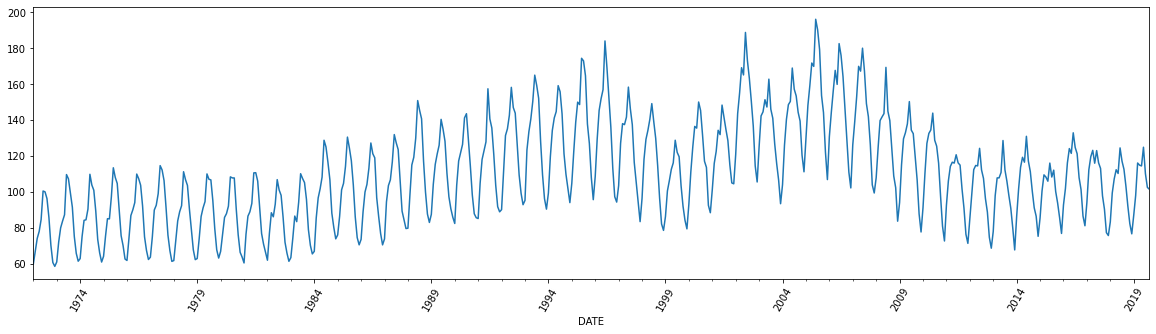

In [ ]:
df['Sales'].plot(figsize = (20,5))
plt.xticks(rotation = 60);

In [ ]:
# Data setinde 1972-01-01 tarihinden 2019-09-01 tarihine kadar (dahil)37 yıl 9 aylık veri var.
# Herbir cycle 12 aylık veriden oluşuyor.

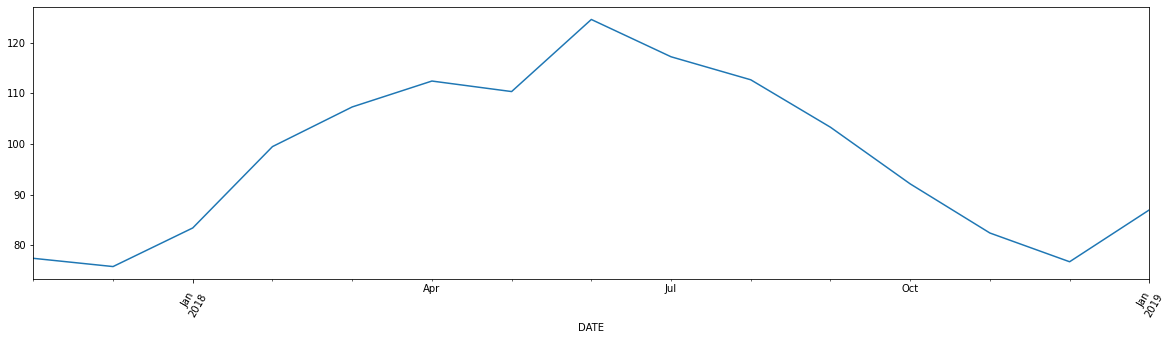

In [ ]:
df['Sales'].loc["2017-11-01" : "2019-01-01"].plot(figsize = (20,5))
plt.xticks(rotation = 60);

## Preprocessing of Data

### Train Test Split

In [ ]:
len(df)  # Data setinde toplam 573 aylık veri olduğunu görüyoruz.

573

In [ ]:
test_size = 24
# Herbir cycle 12 aylık veriden oluşuyor. Bu nedenle bu rakamdan büyük bir test size belirledim.

In [ ]:
test_ind = len(df) - test_size
test_ind

549

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [ ]:
test

,Sales
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.77718508e+00],
       [-1.52639087e+00],
       [-1.27290440e+00],
       [-1.13592383e+00],
       [-9.00912244e-01],
       [-3.41528416e-01],
       [-3.58123662e-01],
       [-4.91168289e-01],
       [-8.64269854e-01],
       [-1.40863422e+00],
       [-1.74732989e+00],
       [-1.82320094e+00],
       [-1.73699893e+00],
       [-1.34458512e+00],
       [-1.06574117e+00],
       [-9.31216147e-01],
       [-8.08781596e-01],
       [-1.82196567e-02],
       [-1.02022649e-01],
       [-3.74489254e-01],
       [-6.58410359e-01],
       [-1.23510313e+00],
       [-1.56618484e+00],
       [-1.72177809e+00],
       [-1.67057555e+00],
       [-1.23369693e+00],
       [-9.18411979e-01],
       [-9.07105871e-01],
       [-6.96840527e-01],
       [-1.27149953e-02],
       [-2.25135567e-01],
       [-3.26318167e-01],
       [-7.34408604e-01],
       [-1.29197639e+00],
       [-1.55830236e+00],
       [-1.73821081e+00],
       [-1.62512853e+00],
       [-1.23112833e+00],
       [-8.8

In [ ]:
test_scaled

array([[-6.99183011e-01],
       [-1.15974439e+00],
       [-1.21719355e+00],
       [-9.47878523e-01],
       [-3.80608685e-01],
       [-1.04128412e-01],
       [ 7.66173909e-02],
       [ 3.25134913e-03],
       [ 5.06009242e-01],
       [ 2.45876895e-01],
       [ 8.53442930e-02],
       [-2.45574890e-01],
       [-6.40571440e-01],
       [-9.83195978e-01],
       [-1.18366387e+00],
       [-8.21939079e-01],
       [-4.29306212e-01],
       [ 2.08789327e-01],
       [ 1.66338425e-01],
       [ 1.51887805e-01],
       [ 5.19308051e-01],
       [ 2.91083371e-05],
       [-2.70423596e-01],
       [-3.06528945e-01]])

## Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

# generator, her defasında 12 aylık veri setini alıp 13'üncü ayın verisini predict yapacak.

In [ ]:
generator[0]

(array([[[-1.77718508],
         [-1.52639087],
         [-1.2729044 ],
         [-1.13592383],
         [-0.90091224],
         [-0.34152842],
         [-0.35812366],
         [-0.49116829],
         [-0.86426985],
         [-1.40863422],
         [-1.74732989],
         [-1.82320094]]]),
 array([[-1.73699893]]))

In [ ]:
X, y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.77718508 -1.52639087 -1.2729044  -1.13592383 -0.90091224 -0.34152842
 -0.35812366 -0.49116829 -0.86426985 -1.40863422 -1.74732989 -1.82320094]
Predict this y: 
 [[-1.73699893]]


In [ ]:
# generator[0] ile X, y = generator[0] kodları aynı (ilk) 12 aylık veri ile 13'üncü ayın predict ini yapıyor.
# Her 2 kod arasında bir input ve output değerleri açısından bir fark yok.

## Modelling & Model Performance

### Import related libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features))) 
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 55)                12540     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 56        
Total params: 12,596
Trainable params: 12,596
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping and Validation Generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [ ]:
len(validation_generator)

12

In [ ]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
561/561 [==============================] - 6s 8ms/step - loss: 0.2586 - val_loss: 0.0325
Epoch 2/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0855 - val_loss: 0.0597
Epoch 3/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0713 - val_loss: 0.0394
Epoch 4/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0669 - val_loss: 0.0377
Epoch 5/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0666 - val_loss: 0.0453
Epoch 6/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0622 - val_loss: 0.0444
Epoch 7/50
561/561 [==============================] - 4s 8ms/step - loss: 0.0628 - val_loss: 0.0431
Epoch 8/50
561/561 [==============================] - 5s 9ms/step - loss: 0.0609 - val_loss: 0.0450
Epoch 9/50
561/561 [==============================] - 5s 9ms/step - loss: 0.0570 - val_loss: 0.0430
Epoch 10/50
561/561 [==============================] - 5s 10ms/step - loss: 0.0578 - val_loss: 0.038

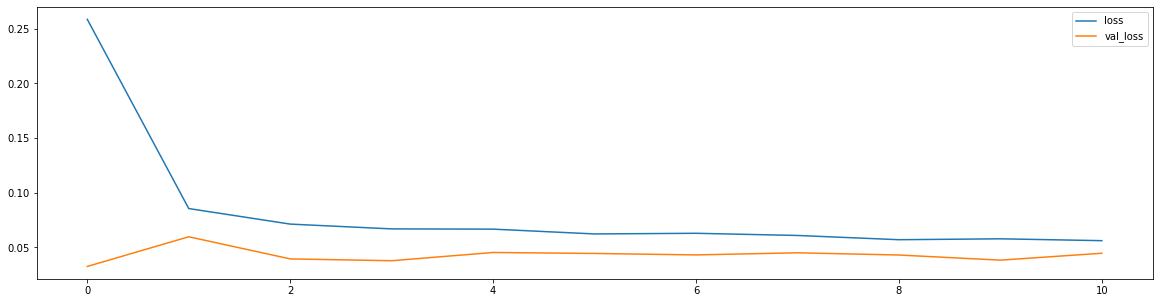

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize = (20,5));

#### Evaluate on Test Data

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [ ]:
y_pred = model.predict(validation_generator)

In [ ]:
y_pred

# Data setindeki son 24 aylık veriyi test için ayırdık.
# Test datası içinden stride 1 olacak şekilde 12 lik gruplar halinde işlem yaparak 12 değer generate yaptık. 
# Bu değerlerin predict ini alıyoruz.

array([[-0.6756794 ],
       [-0.96929806],
       [-1.1292852 ],
       [-1.0520179 ],
       [-0.5608699 ],
       [-0.17695604],
       [ 0.24035095],
       [ 0.4036691 ],
       [ 0.430515  ],
       [ 0.36352706],
       [-0.14409032],
       [-0.601026  ]], dtype=float32)

In [ ]:
len(y_pred)

12

In [ ]:
test_scaled[-12:]

# y_pred i test datasının son 12 verisi ile karşılaştırıyorum.
# Çünkü predict ler onlara karşılık geliyor

array([[-6.40571440e-01],
       [-9.83195978e-01],
       [-1.18366387e+00],
       [-8.21939079e-01],
       [-4.29306212e-01],
       [ 2.08789327e-01],
       [ 1.66338425e-01],
       [ 1.51887805e-01],
       [ 5.19308051e-01],
       [ 2.91083371e-05],
       [-2.70423596e-01],
       [-3.06528945e-01]])

In [ ]:
eval_metrics(test_scaled[-12:], y_pred)

r2_score: 0.827166439586711 
 mae: 0.1708072947009854 
 mse: 0.04458356398436982 
 rmse: 0.21114820383884353


In [ ]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [ ]:
train.shape

(549, 1)

In [ ]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.8668815831700112 
 mae: 0.1540027478244883 
 mse: 0.03677729173677453 
 rmse: 0.1917740642964385


#### Inverse Transformations and Comparing

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

,Sales,Predictions
DATE,,
2017-10-01,90.473,90.456
2017-11-01,77.438,84.249
2017-12-01,75.812,84.800
2018-01-01,83.434,93.586
2018-02-01,99.490,103.556
2018-03-01,107.315,110.630
2018-04-01,112.431,116.392
2018-05-01,110.354,121.407
2018-06-01,124.584,123.527


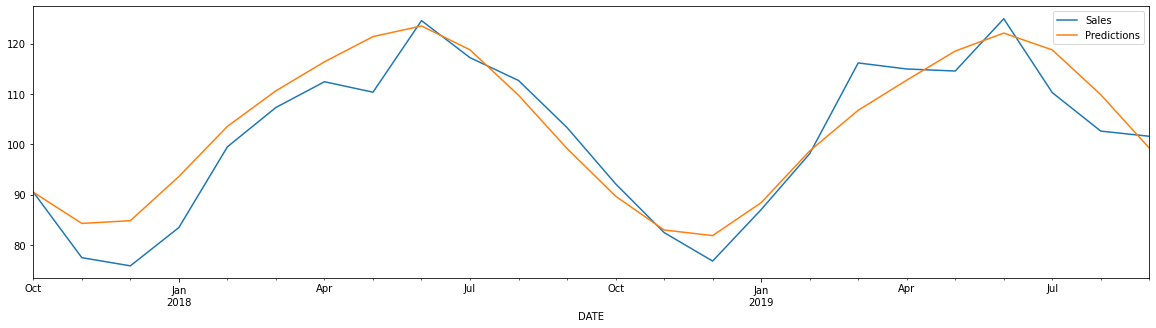

In [ ]:
test.plot(figsize = (20,5));

#### Calculation R2 Score and Error Metrics

In [ ]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.8668815940271792 
 mae: 4.358783473714192 
 mse: 29.461401526395974 
 rmse: 5.4278358050327915


### with "relu" activation function

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 60)                14880     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping and Validation Generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [ ]:
len(validation_generator)

12

In [ ]:
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
561/561 [==============================] - 5s 7ms/step - loss: 0.5336 - val_loss: 0.1978
Epoch 2/50
561/561 [==============================] - 6s 10ms/step - loss: 0.3480 - val_loss: 0.0534
Epoch 3/50
561/561 [==============================] - 5s 9ms/step - loss: 0.1176 - val_loss: 0.0451
Epoch 4/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0916 - val_loss: 0.0366
Epoch 5/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0730 - val_loss: 0.0425
Epoch 6/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0780 - val_loss: 0.0417
Epoch 7/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0712 - val_loss: 0.0447
Epoch 8/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0726 - val_loss: 0.0708
Epoch 9/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0690 - val_loss: 0.0576
Epoch 10/50
561/561 [==============================] - 3s 6ms/step - loss: 0.0686 - val_loss: 0.041

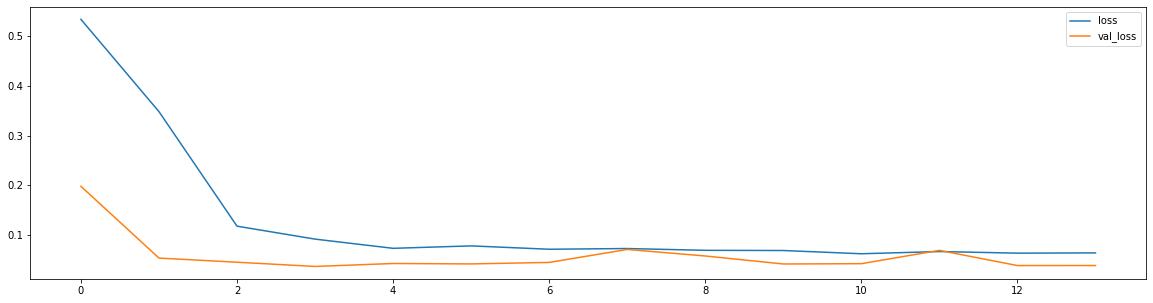

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize = (20,5));

#### Evaluate on Test Data

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [ ]:
y_pred = model.predict(validation_generator)

In [ ]:
y_pred

array([[-0.6994437 ],
       [-0.97045135],
       [-1.0962414 ],
       [-0.94362366],
       [-0.4711693 ],
       [-0.10576846],
       [ 0.31464037],
       [ 0.3622599 ],
       [ 0.39685085],
       [ 0.41862118],
       [-0.15244642],
       [-0.5597883 ]], dtype=float32)

In [ ]:
test_scaled[-12:]

array([[-6.40571440e-01],
       [-9.83195978e-01],
       [-1.18366387e+00],
       [-8.21939079e-01],
       [-4.29306212e-01],
       [ 2.08789327e-01],
       [ 1.66338425e-01],
       [ 1.51887805e-01],
       [ 5.19308051e-01],
       [ 2.91083371e-05],
       [-2.70423596e-01],
       [-3.06528945e-01]])

In [ ]:
eval_metrics(test_scaled[-12:], y_pred)

r2_score: 0.8509758552613853 
 mae: 0.159008723526642 
 mse: 0.038441767190830624 
 rmse: 0.1960657216109706


In [ ]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [ ]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.5984473618246976 
 mae: 0.28236184767489203 
 mse: 0.11093895851169426 
 rmse: 0.33307500433339976


#### Inverse Transformations and Comparing

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

,Sales,Predictions
DATE,,
2017-10-01,90.473,90.465
2017-11-01,77.438,84.476
2017-12-01,75.812,85.246
2018-01-01,83.434,95.981
2018-02-01,99.490,108.363
2018-03-01,107.315,117.654
2018-04-01,112.431,124.433
2018-05-01,110.354,127.128
2018-06-01,124.584,128.762


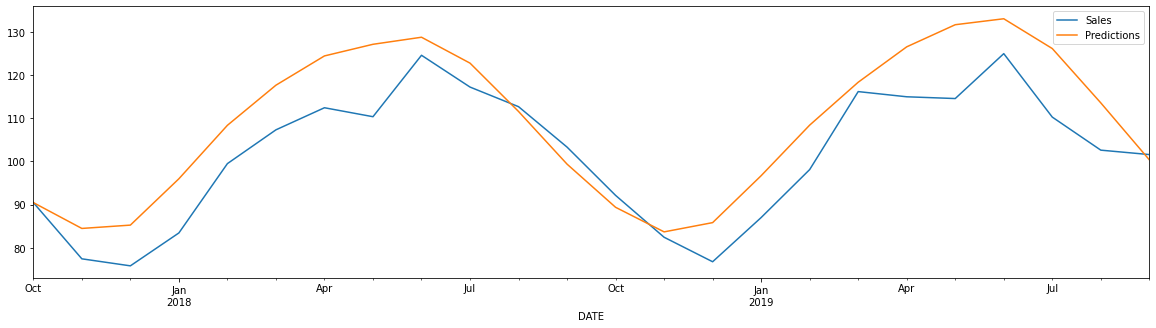

In [ ]:
test.plot(figsize = (20,5));

#### Calculation R2 Score and Error Metrics

In [ ]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.598447269912052 
 mae: 7.991768816121419 
 mse: 88.87055196226565 
 rmse: 9.427117903275935


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [ ]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [ ]:
model = Sequential()
model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=50)

Epoch 1/50
561/561 [==============================] - 8s 7ms/step - loss: 0.2730
Epoch 2/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0824
Epoch 3/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0729
Epoch 4/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0676
Epoch 5/50
561/561 [==============================] - 4s 6ms/step - loss: 0.0663
Epoch 6/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0611
Epoch 7/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0618
Epoch 8/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0566
Epoch 9/50
561/561 [==============================] - 4s 7ms/step - loss: 0.0526
Epoch 10/50
561/561 [==============================] - 5s 9ms/step - loss: 0.0524
Epoch 11/50
561/561 [==============================] - 6s 11ms/step - loss: 0.0517
Epoch 12/50
561/561 [==============================] - 7s 13ms/step - loss: 0.0511
Epoch 13/50
561/561 [==

In [ ]:
scaled_full_data.shape

(573, 1)

In [ ]:
scaled_full_data[-length:].shape

(12, 1)

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
# tüm datamın son 12 ye 1 lik kısmını aldım. artık bunu ileriye doğru predict te (forecast) kullanıcam
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

array([[ 90.77124 ],
       [ 79.60926 ],
       [ 73.39487 ],
       [ 82.95762 ],
       [ 98.966125],
       [105.653946],
       [108.61446 ],
       [111.57723 ],
       [124.59901 ],
       [112.46559 ],
       [106.1066  ],
       [ 92.40073 ]], dtype=float32)

In [ ]:
df

,Sales
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [ ]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [ ]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-10-01,90.771
2019-11-01,79.609
2019-12-01,73.395
2020-01-01,82.958
2020-02-01,98.966
2020-03-01,105.654
2020-04-01,108.614
2020-05-01,111.577
2020-06-01,124.599
2020-07-01,112.466


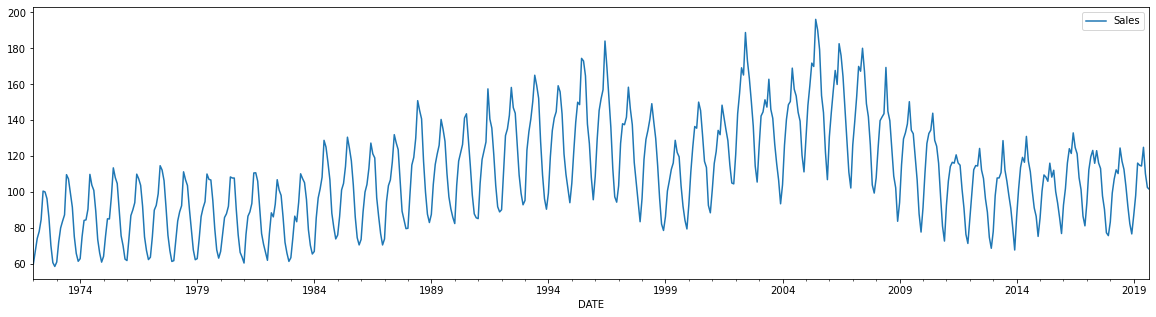

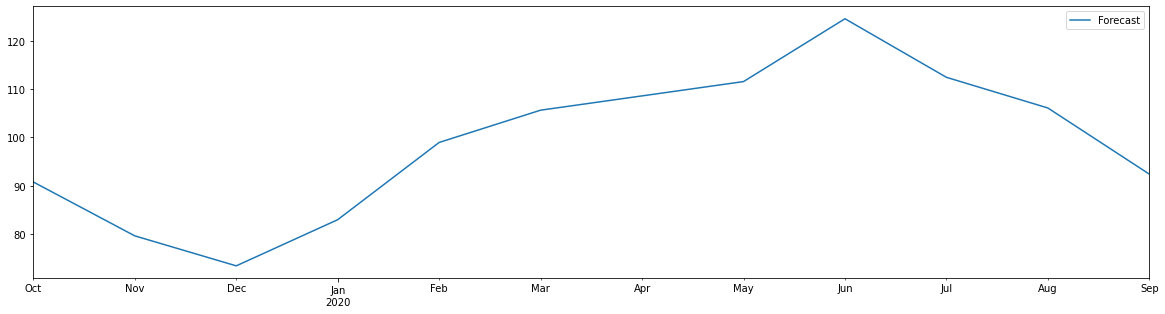

In [ ]:
df.plot(figsize = (20,5))
forecast_df.plot(figsize = (20,5));

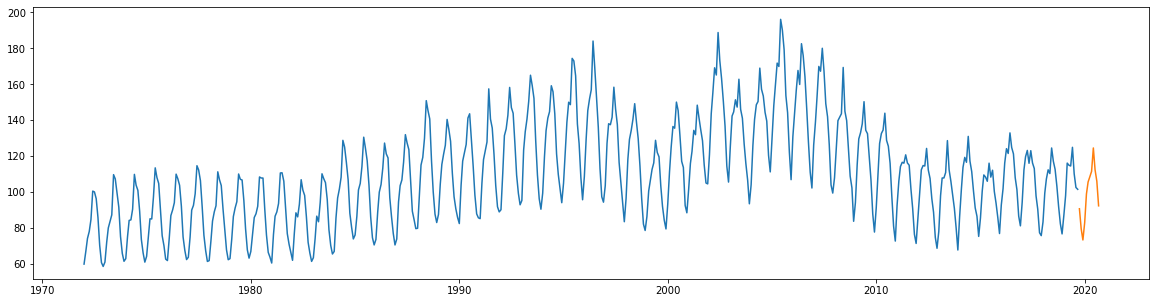

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast']);

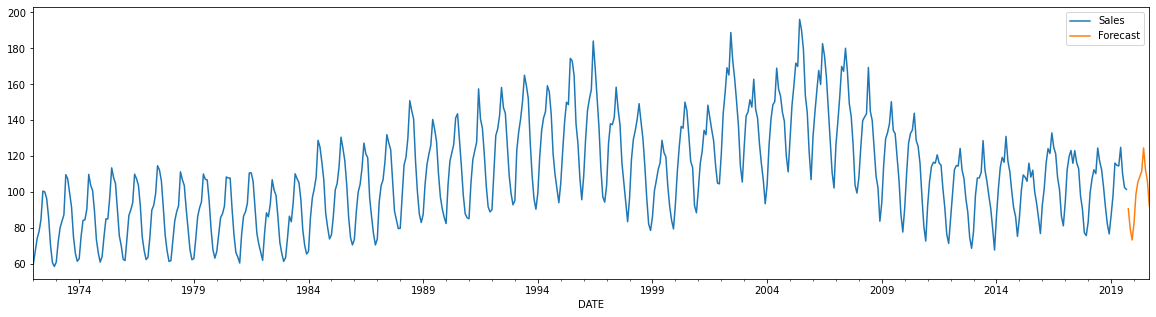

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20,5));

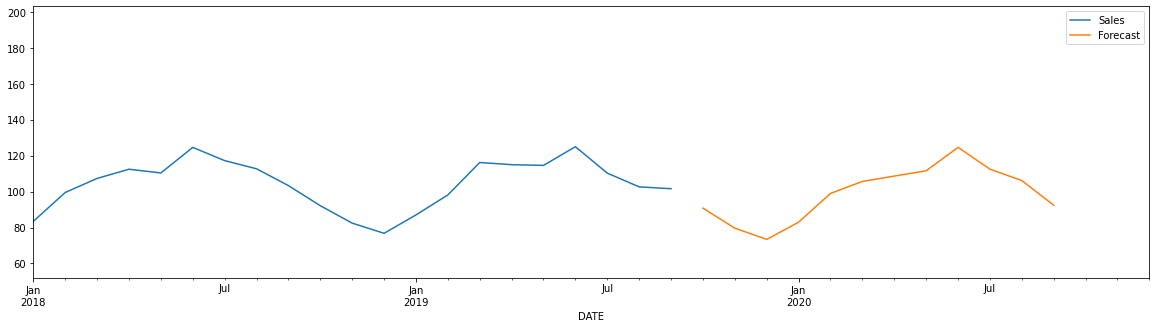

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20,5))
plt.xlim('2018-01-01', '2020-12-01');